In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pymongo
import pickle
from scipy.stats import spearmanr,mannwhitneyu
import matplotlib.patches as mpatches


%matplotlib inline
sns.set_context("poster")

In [2]:
client = pymongo.MongoClient()
db = client.swatford

In [3]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [4]:
%run ../scripts/equations.py

In [5]:
n = db.genes.descs.original.find().count()
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)

In [6]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]

In [7]:
desc_children = []
for doc in db.medline.descs.find({"uid":{"$in":bc_uids}}):
    desc_children.append(doc["uid"])
    desc_children+=db.medline.descs.distinct("uid",{"ancestors":{"$in":doc["tn"]}})
desc_children = set(desc_children)

In [8]:
bc_genes = pd.read_pickle("../data/SSI/ssi_gene_list.p")

In [9]:
desc_name_map = pd.Series({doc["uid"]:doc["name"] for doc in db.medline.descs.find()})

In [10]:
bc_results = gene_uid[(gene_uid.gd_freq>2) &
         (gene_uid.uid.isin(desc_children))][["gene_id","uid","npmi"]].copy()
# .groupby("gene_id").mean()

In [11]:
bc_results["npmi_rank"] = [None]*len(bc_results)
bc_results = bc_results[["gene_id","uid","npmi","npmi_rank"]].pivot(index="gene_id",columns="uid")

In [12]:
bc_results = bc_results.swaplevel(1,0,axis=1)
for d in bc_results.columns.get_level_values("uid"):
    bc_results[d,"npmi"].update(pd.Series(index = bc_results[d][bc_results[d,
                                                                    "npmi"]<=0].npmi.index.values,data=np.nan))
    bc_results[d,"npmi_rank"] = bc_results[d,"npmi"].rank(ascending=False,na_option="bottom")

In [13]:
bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].min(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].max(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean()

(3683.0, 7710.022988505747, 6517.0837638671965)

In [ ]:
# bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].sort_values()

In [14]:
genie_results = pd.read_table("../data/SSI/genie_results_20170718145030538722642_table.txt").set_index("GeneID")

In [15]:
genie_results_bn = pd.read_table(
    "../data/SSI/genie_results_breast_neoplasms_20170718153344381245235_table.txt").set_index("GeneID")

In [43]:
h.__dict__

{'_A': None,
 '_agg_filter': None,
 '_alpha': None,
 '_animated': False,
 '_antialiaseds': (True,),
 '_axes': None,
 '_clipon': True,
 '_clippath': None,
 '_contains': None,
 '_edgecolors': 'face',
 '_facecolors': array([[ 0.29803922,  0.44705882,  0.69019608,  1.        ]]),
 '_gid': None,
 '_hatch': None,
 '_hatch_color': (0.0, 0.0, 0.0, 1),
 '_is_filled': True,
 '_is_stroked': False,
 '_label': 'Génie rank (214 MeSH terms)\nSpearman Rank Correlation = 0.561',
 '_linestyles': [(None, None)],
 '_linewidths': (0.48,),
 '_mouseover': False,
 '_offset_position': 'screen',
 '_offsets': array([[ 16. ,   4.2]]),
 '_oid': 0,
 '_original_edgecolor': 'face',
 '_original_facecolor': (0.2980392156862745,
  0.4470588235294118,
  0.6901960784313725),
 '_path_effects': None,
 '_paths': [Path(array([[ 0.        , -0.5       ],
         [ 0.13260155, -0.5       ],
         [ 0.25978994, -0.44731685],
         [ 0.35355339, -0.35355339],
         [ 0.44731685, -0.25978994],
         [ 0.5       , -0.1

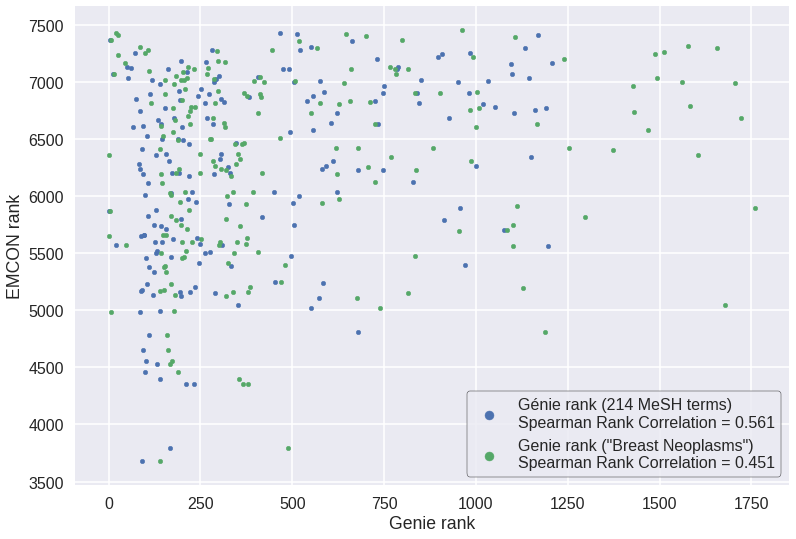

In [48]:
fig, ax = plt.subplots()
results = pd.DataFrame([pd.Series(genie_results.loc[bc_genes].Rank),
               bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes]
                       ],
             index=["Genie rank","EMCON rank"]).T
results2 = pd.DataFrame([pd.Series(genie_results_bn.loc[bc_genes].Rank),
               bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes]
                        ],
             index=["Genie rank","EMCON rank"]).T
p1 = results.plot(x="Genie rank",y="EMCON rank",kind="scatter",ax=ax,legend=True,
        label=f"Génie rank (214 MeSH terms)\nSpearman Rank Correlation = {round(spearmanr(results.values)[0],3)}")
p2 = results2.plot(x="Genie rank",y="EMCON rank",kind="scatter",color=sns.color_palette()[1],ax=ax,legend=True,
        label=f"""Genie rank ("Breast Neoplasms")\nSpearman Rank Correlation = {round(spearmanr(results2.values)[0],3)}""")
handles,labels = ax.get_legend_handles_labels()
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor("black")
leg.legendHandles[0]
for h in leg.legendHandles:
    h._sizes = [80]
plt.savefig("genie_comp.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [ ]:
results = pd.DataFrame([pd.Series(genie_results.loc[bc_genes].Rank),
               bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes]
                       ],
             index=["Genie rank","EMCON rank"]).T
results2 = pd.DataFrame([pd.Series(genie_results_bn.loc[bc_genes].Rank),
               bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes]
                        ],
             index=["Genie rank","EMCON rank"]).T
fig = plt.figure(figsize=(20.0,7.0))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122,sharey=ax)


results.plot(x="Genie rank",y="EMCON rank",kind="scatter",ax=ax)
ax.text(0.97,0.05,f"Spearman Rank Correlation = {round(spearmanr(results.values)[0],3)}",
        horizontalalignment="right",
        transform=ax.transAxes)
ax.set_xlabel("Génie rank\n(214 MeSH terms)")

results2.plot(x="Genie rank",y="EMCON rank",kind="scatter",ax=ax2)
ax2.text(2,0.05,f"Spearman Rank Correlation = {round(spearmanr(results2.values)[0],3)}",
        horizontalalignment="right",
        transform=ax.transAxes)
# plt.title("""Rank Correlation of ESR gene set\nGenie Results using "Breast Neoplasms" compared to EMCON""")
ax2.set_xlabel("""Genie rank\n("Breast Neoplasms")""")

ax.text(-0.02, 1.125, 'A',
         fontweight="bold",
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

ax.text(1.025, 1.125, 'B',
         fontweight="bold",
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)
left, width = -0.15, 1.16
bottom, height = -0.2, 1.4
p = mpatches.Rectangle(
    (left, bottom), width, height,
    fill=False, transform=ax.transAxes, clip_on=False, color="black"
    )

left2,width2 = 1.01,1.03

p2 = mpatches.Rectangle(
    (left2, bottom), width2, height,
    fill=False, transform=ax.transAxes, clip_on=False, color="black"
    )
ax.add_patch(p)
ax.add_patch(p2)
plt.tight_layout()
plt.savefig("genie_comp.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [ ]:
len(genie_results),len(bc_results),len(genie_results_bn)

In [ ]:
spearmanr(results.values)

In [ ]:
spearmanr(results2.values)

In [ ]:
results[results["Genie rank"].isnull()].index.values

In [ ]:
results2[results2["Genie rank"].isnull()].index.values